This notebook substitutes some classes in an experience by "debug" versions of them, which write to file almost every intermidiate step, as to help detect any incoherence in the code

In [1]:
PATH_TO_STORE_EXPERIMENTS = "data\\rl_training"

In [2]:
experiment_name = "dqn_multi_agent"

# Preparation before loading experiment

## Change logging system

In [3]:
from automl.loggers.logger_component import LoggerSchema 

LoggerSchema.get_schema_parameter_signature("write_to_file_when_text_lines_over").change_default_value(-1)
LoggerSchema.get_schema_parameter_signature("necessary_logger_level").change_default_value("DEBUG")

In [4]:
from automl.loggers.component_with_results import ResultLogger

ResultLogger.get_schema_parameter_signature("save_results_on_log").change_default_value(True)

# The base Experiment

## Base Configuration

In [5]:
from automl.rl.whole_configurations import rl_multi_agent_pipeline as base_rl_configuration

rl_pipeline_config = base_rl_configuration.config_dict()

## Base Configuration Interpretation

In [6]:
rl_pipeline_input = rl_pipeline_config["input"]

rl_trainer_tuple = rl_pipeline_input["rl_trainer"]
rl_trainer_input = rl_trainer_tuple[1]

agents_input = rl_pipeline_input["agents_input"]

policy_tuple = agents_input["policy"]
policy_input = policy_tuple[1]

agents_trainers_input = rl_trainer_input["agents_trainers_input"]

In [7]:
state_translator_tuple = agents_input["state_translator"]
state_translator_input = state_translator_tuple[1]

In [8]:
learner_tuple = agents_trainers_input["learner"]
learner_input = learner_tuple[1]

optimizer_tuple = learner_input["optimizer"]
optimizer_input = optimizer_tuple[1]

In [9]:
memory_tuple = agents_trainers_input["memory"]
memory_input = memory_tuple[1]

In [10]:
environment_tuple = rl_pipeline_input["environment"]
environment_input = environment_tuple[1]

In [11]:
exploration_strategy_tuple = agents_trainers_input["exploration_strategy"]
exploration_strategy_input = exploration_strategy_tuple[1]

# Changes to the base configuration

## Code to help alter experiment

In [12]:
def substitute_value_in_dict(dict_with_value : dict, key, new_value):
    print(f"Old value for key '{key}': {dict_with_value.get(key, None)}, new value: {new_value}")
    dict_with_value[key] = new_value

def remove_value_in_dict(dict_with_value : dict, key, new_value):
    print(f"Old value for key '{key}': {dict_with_value.get(key, None)}, to be removed...")
    dict_with_value.pop(key, None)



def substitute_tuple_value_in_dict(dict_with_tuple : dict, key, tuple_index, new_value):

    tuple_value : tuple = dict_with_tuple[key]

    print(f"Old value for tuple pos {tuple_index}: {tuple_value[tuple_index]}, new value: {new_value}")
    new_tuple_value = tuple( new_value if tuple_index == i else tuple_value[i] for i in range(len(tuple_value)) )

    dict_with_tuple[key] = new_tuple_value


## Changes to debug

### Classes to Help Debug

In [13]:
from automl.rl.trainers.agent_trainer_component import AgentTrainer
from automl.rl.trainers.debug.agent_trainer_debug import AgentTrainerDebug

agent_trainer_class : type[AgentTrainer] = rl_trainer_input["default_trainer_class"]

# we had our own debug functionality
class AgentTrainerDQNDebugClass(AgentTrainerDebug, agent_trainer_class):
    pass
        

In [14]:
from automl.component import requires_input_proccess
from automl.rl.learners.debug.learner_debug import DQNLearnerDebug
from automl.rl.learners.q_learner import DeepQLearnerSchema, DoubleDeepQLearnerSchema
import torch

class CustomDQNLearnerDebug(DQNLearnerDebug, DoubleDeepQLearnerSchema):
    is_debug_schema = True
    pass


In [15]:

from automl.ml.memory.memory_components import MemoryComponent


memory_class : type[MemoryComponent] = memory_tuple[0]

from automl.ml.memory.debug.memory_debug import MemoryDebug


class TorchMemoryComponentDebug(MemoryDebug, memory_class):
    pass

In [16]:
from automl.rl.trainers.rl_trainer.parallel_rl_trainer import RLTrainerComponentParallel
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


class RLTrainerDebug(RLTrainerComponentParallel):

    is_debug_schema = True

    def _proccess_input_internal(self):
        super()._proccess_input_internal()

        plt.ion()  # turn on interactive mode

        self.fig, self.ax = plt.subplots(figsize=(6,4))


    def run_episode_step_for_agent_name(self, i_episode, agent_name):

        done = super().run_episode_step_for_agent_name( i_episode, agent_name)

        self.lg.writeLine(f"Doing episode step in episode {i_episode} for agent {agent_name} was over: {done}", file="observations.txt", use_time_stamp=False)
                        
        return done

    def proccess_env_step_for_agents(self, i_episode, agent_names, actions, observations, rewards, terminations, truncations):

        self.lg.writeLine(f"\nIn episode {self.values['episodes_done']}, total step {self.values['total_steps']}, episode step {self.values['episode_steps']}:\n    actions: {actions}\n    rewards: {rewards}\n    terminations: {terminations}\n    truncations: {truncations}\n", file="observations.txt", use_time_stamp=False)

        return super().proccess_env_step_for_agents(i_episode, agent_names, actions, observations, rewards, terminations, truncations)
    
    def run_single_episode(self, i_episode):
                        
        super().run_single_episode(i_episode)

        clear_output(wait=True)

        self.ax.clear()

        self.get_results_logger().plot_confidence_interval(x_axis='episode', y_column='episode_reward',show_std=False, to_show=False, ax=self.ax)
        self.get_results_logger().plot_linear_regression(x_axis='episode', y_axis='episode_reward', to_show=False, y_label='linear', ax=self.ax)

        self.ax.set_title(f"Training progress (update {i_episode})")
        display(self.fig)



In [17]:
from automl.ml.optimizers.debug.debug_optimizers import AdamOptimizerDebug

In [18]:
#from automl.rl.trainers.debug.rl_trainer_debug import RLTrainerDebug
from automl.fundamentals.translator.translator import Translator
from automl.rl.policy.policy import ComponentWithLogging

import torch
torch.set_printoptions(threshold=float('inf'), linewidth=30000)


translator_type : type[Translator] = state_translator_tuple[0]


class TranslatorDebug(translator_type, ComponentWithLogging):

    is_debug_schema = True


    def translate_state(self, state):
        
        self.lg.writeLine(f"-----------------------------------------------\nTranslating:\n\n{state}\ninto", use_time_stamp=False, file="translations.txt")
        to_return = super().translate_state(state)
        self.lg.writeLine(f"\n{to_return}\n-----------------------------------------------", use_time_stamp=False, file="translations.txt")
        return to_return



In [19]:
from automl.ml.models.neural_model import FullyConnectedModelSchema


class FullyConnectedModelDebug(FullyConnectedModelSchema, ComponentWithLogging):

    @requires_input_proccess
    def predict(self, state):
        self.lg.writeLine(f"Predicting for input with state {state.shape}, while input size is {self.input_size}",  use_time_stamp=False, file="predictions.txt")
        to_return = self.model(state)
        self.lg.writeLine(f"To return shape: {to_return.shape}\n",  use_time_stamp=False, file="predictions.txt")
        return to_return

In [20]:
from automl.rl.environment.aec_environment import EnvironmentComponent
from automl.rl.environment.debug.parallel_debug import ParallelEnvironmentComponentDebug

environment_type : type[EnvironmentComponent] = environment_tuple[0]


class EnvironmentDebug(ParallelEnvironmentComponentDebug, environment_type):
    pass

### Change experiment with Debug variants

In [21]:
substitute_value_in_dict(rl_trainer_input, "default_trainer_class", AgentTrainerDQNDebugClass)


Old value for key 'default_trainer_class': <class 'automl.rl.trainers.agent_trainer_component_dqn.AgentTrainerDQN'>, new value: <class '__main__.AgentTrainerDQNDebugClass'>


In [22]:
substitute_tuple_value_in_dict(agents_trainers_input, "learner", 0, CustomDQNLearnerDebug)

substitute_value_in_dict(learner_input, "compare_old_and_new_target_predictions", False)
substitute_value_in_dict(learner_input, "compare_old_and_new_target_model_params", False)
substitute_value_in_dict(learner_input, "compare_old_and_new_model_predictions", False)

Old value for tuple pos 0: <class 'automl.rl.learners.q_learner.DeepQLearnerSchema'>, new value: <class '__main__.CustomDQNLearnerDebug'>
Old value for key 'compare_old_and_new_target_predictions': None, new value: False
Old value for key 'compare_old_and_new_target_model_params': None, new value: False
Old value for key 'compare_old_and_new_model_predictions': None, new value: False


In [23]:
#substitute_tuple_value_in_dict(agents_input, "state_translator", 0, TranslatorDebug)

In [24]:
substitute_tuple_value_in_dict(agents_trainers_input, "memory", 0, TorchMemoryComponentDebug)

Old value for tuple pos 0: <class 'automl.ml.memory.torch_memory_component.TorchMemoryComponent'>, new value: <class '__main__.TorchMemoryComponentDebug'>


In [25]:
substitute_tuple_value_in_dict(rl_pipeline_input, "rl_trainer", 0, RLTrainerDebug)

Old value for tuple pos 0: <class 'automl.rl.trainers.rl_trainer.parallel_rl_trainer.RLTrainerComponentParallel'>, new value: <class '__main__.RLTrainerDebug'>


In [26]:
#substitute_tuple_value_in_dict(learner_input, "optimizer", 0, AdamOptimizerDebug)

In [27]:
substitute_tuple_value_in_dict(policy_input, "model", 0, FullyConnectedModelDebug)

Old value for tuple pos 0: <class 'automl.ml.models.neural_model.FullyConnectedModelSchema'>, new value: <class '__main__.FullyConnectedModelDebug'>


In [28]:
substitute_tuple_value_in_dict(rl_pipeline_input, "environment", 0, EnvironmentDebug)

Old value for tuple pos 0: <class 'automl.rl.environment.pettingzoo.parallel_petting_zoo_env.PettingZooEnvironmentWrapperParallel'>, new value: <class '__main__.EnvironmentDebug'>


## Manual Hyperparameter Tuning

### Experiment

### Base Model

### Other value changes

In [29]:
#rl_trainer_input["limit_total_steps"] = 1000

#rl_trainer_input.pop("limit_total_steps", None)

#rl_trainer_input["num_episodes"] = 4000


In [30]:
#agents_trainers_input["learning_start_step_delay"] = 5000
#agents_trainers_input["learning_start_ep_delay"] = 150

#substitute_value_in_dict(agents_trainers_input, "learning_start_ep_delay", 2897)

In [31]:
substitute_value_in_dict(agents_trainers_input, "optimization_interval", 32)
substitute_value_in_dict(agents_trainers_input, "times_to_learn", 2)

Old value for key 'optimization_interval': 50, new value: 32
Old value for key 'times_to_learn': 2, new value: 2


In [32]:
substitute_value_in_dict(agents_trainers_input, "batch_size", 32)

Old value for key 'batch_size': None, new value: 32


In [33]:
substitute_value_in_dict(memory_input, "capacity", 32)
substitute_value_in_dict(memory_input, "device", "cpu")

Old value for key 'capacity': 100, new value: 32
Old value for key 'device': None, new value: cpu


In [34]:
#substitute_value_in_dict(environment_input, "render_mode", "human")

In [35]:
#optimizer_input["clip_grad_norm"] = 0.1

#substitute_value_in_dict(optimizer_input, "clip_grad_value", 0.2956984463839789)

#substitute_value_in_dict(optimizer_input, "learning_rate", 0.006807860813523758)

In [36]:
#substitute_value_in_dict(agents_trainers_input, "discount_factor", 0.8790365307757482)

In [37]:
#substitute_value_in_dict(learner_input, "target_update_rate", 0.5511208693081078)

In [38]:
#substitute_value_in_dict(exploration_strategy_input, "epsilon_end", 0.009535369612528788)

# Gen RL Pipeline

In [39]:

from automl.rl.rl_pipeline import RLPipelineComponent
from automl.utils.json_utils.json_component_utils import gen_component_from

rl_pipeline : RLPipelineComponent = gen_component_from(rl_pipeline_config)

In [40]:
rl_pipeline.pass_input({
    "base_directory" : PATH_TO_STORE_EXPERIMENTS,
                        "artifact_relative_directory" : experiment_name,
                        "create_new_directory" : True,
                        "do_full_setup_of_seed" : True}
                        )

experiment_path = rl_pipeline.get_artifact_directory()

print(f"Experiment path: {experiment_path}")

Experiment path: data\rl_training\dqn_multi_agent_37


# Do the training

In [41]:
from automl.loggers.global_logger import activate_global_logger

activate_global_logger(rl_pipeline.get_artifact_directory())

Global logger is trying to be activated in directory: data\rl_training\dqn_multi_agent_37
[2025-12-03 18:29:02] Global logger activation as ended, activated in data\rl_training\dqn_multi_agent_37\_global_logger


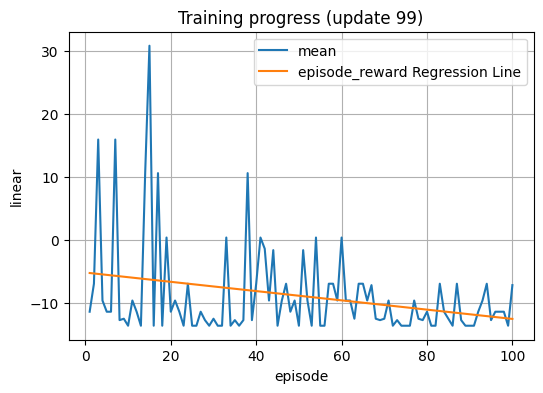

[2025-12-04 06:08:31] WARNING: Exception when decoding obj: Discrete(3), Object of type Discrete is not JSON serializable
[2025-12-04 06:08:31] WARNING: Exception when decoding obj: Model_Class(
  (network): Sequential(
    (0): Linear(in_features=268800, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
), Object of type Model_Class is not JSON serializable
[2025-12-04 06:08:31] WARNING: Exception when decoding obj: cuda, Object of type device is not JSON serializable
[2025-12-04 06:08:31] WARNING: Exception when decoding obj: torch.int64, Object of type dtype is not JSON serializable
[2025-12-04 06:08:31] WARNING: Exception when decoding obj: Discrete(3), Object of type Discrete is not JSON serializable
[2025-12-04 06:08:31] WARNING: Exception when decoding obj: Model_Class(
  (

{}

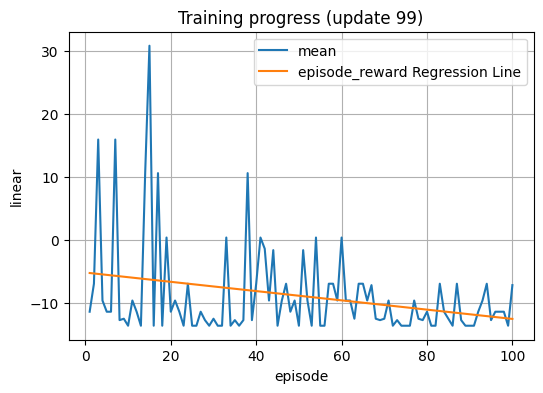

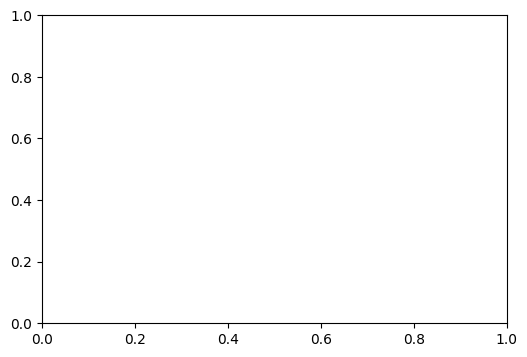

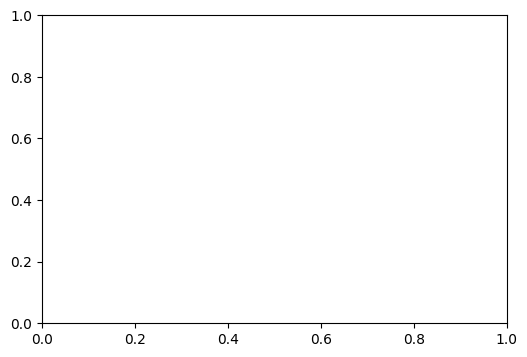

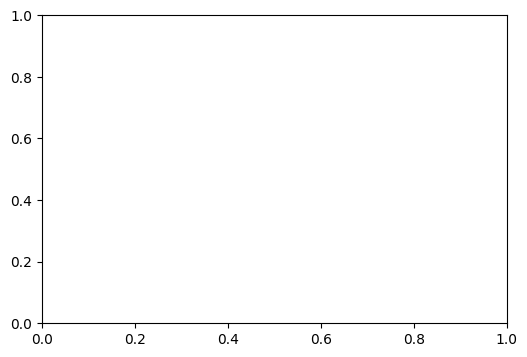

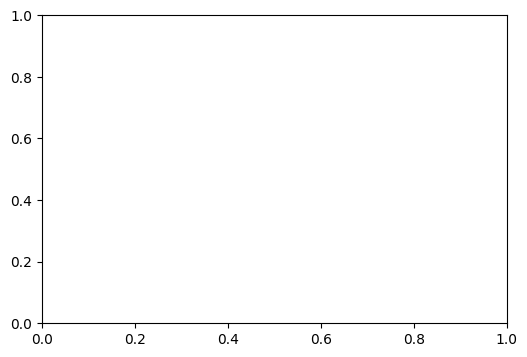

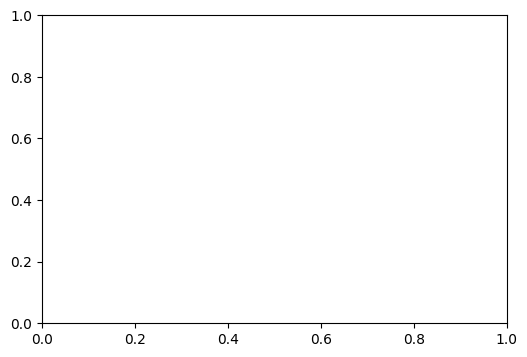

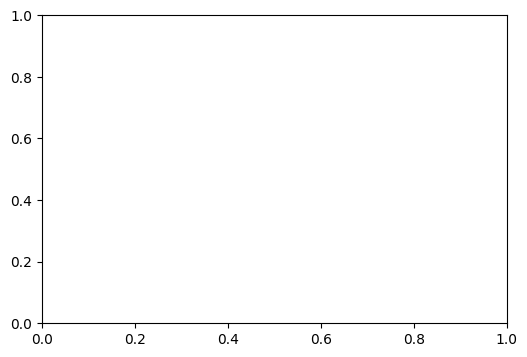

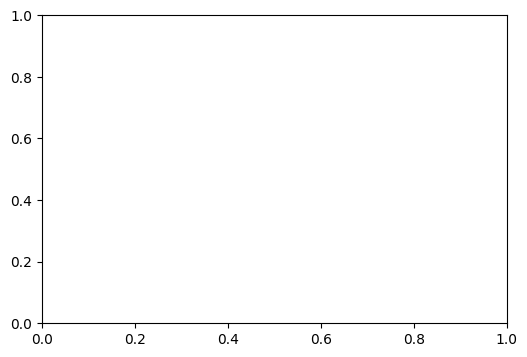

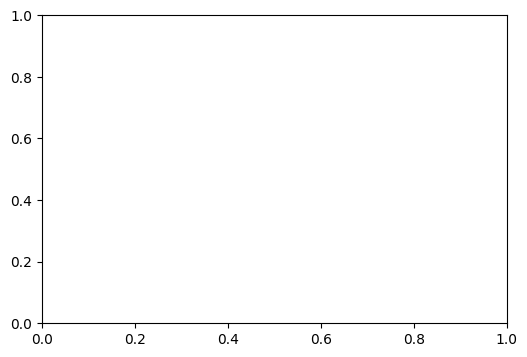

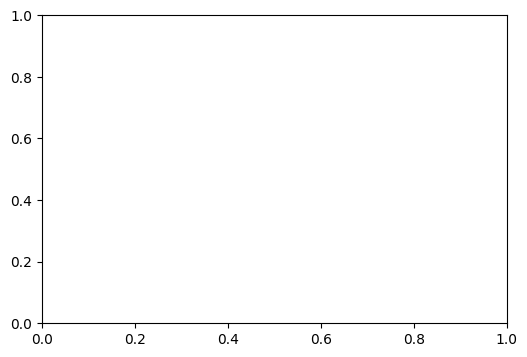

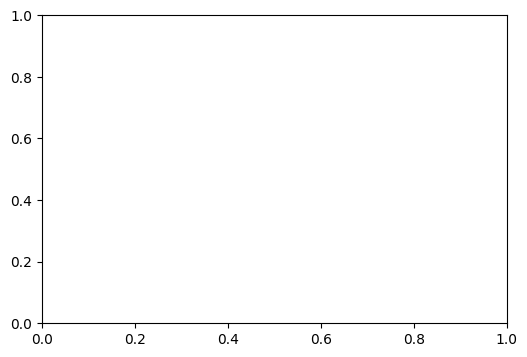

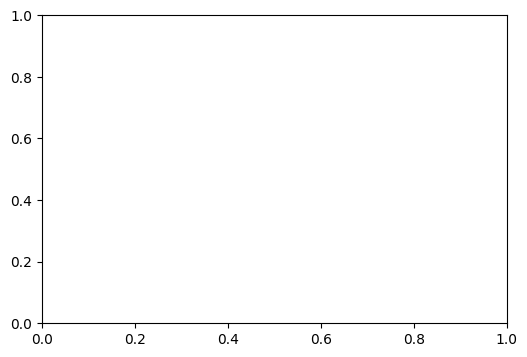

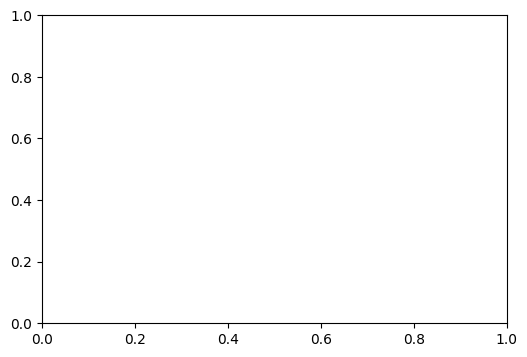

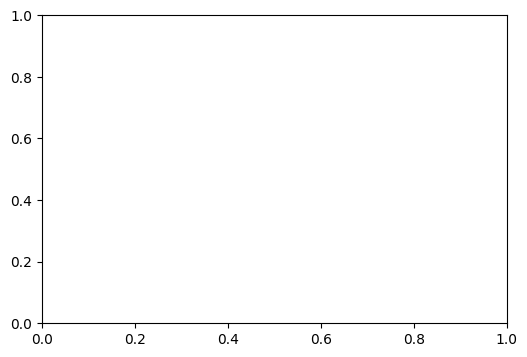

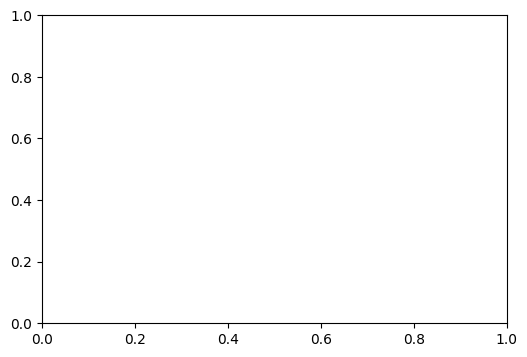

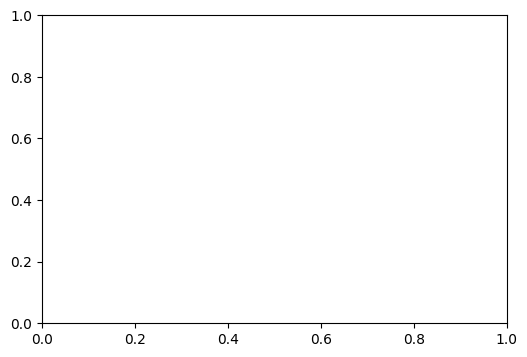

In [42]:
rl_pipeline.run()

## Save configuration

In [43]:
#rl_pipeline.save_configuration(save_exposed_values=True)
from automl.basic_components.state_management import save_state

save_state(rl_pipeline, save_definition=True)

[2025-12-04 06:08:36] WARNING: Exception when decoding obj: cuda, Object of type device is not JSON serializable
[2025-12-04 06:08:36] WARNING: Exception when decoding obj: Box(0, 255, (280, 480, 3), uint8), Object of type Box is not JSON serializable
[2025-12-04 06:08:36] WARNING: Exception when decoding obj: Discrete(3), Object of type Discrete is not JSON serializable
[2025-12-04 06:08:36] WARNING: Exception when decoding obj: cuda, Object of type device is not JSON serializable
[2025-12-04 06:08:36] WARNING: Exception when decoding obj: Box(0, 255, (280, 480, 3), uint8), Object of type Box is not JSON serializable
[2025-12-04 06:08:36] WARNING: Exception when decoding obj: cuda, Object of type device is not JSON serializable
[2025-12-04 06:08:36] WARNING: Exception when decoding obj: Box(0, 255, (280, 480, 3), uint8), Object of type Box is not JSON serializable
[2025-12-04 06:08:36] WARNING: Exception when decoding obj: cuda, Object of type device is not JSON serializable
[2025-12-

## See Results

In [44]:
AGGREGATE_NUMBER = 5

In [45]:

from automl.loggers.result_logger import RESULTS_FILENAME, ResultLogger

results_directory = f"{experiment_path}\\RLTrainerComponent"
    
results_logger = ResultLogger(input={
                                        "results_filename" : RESULTS_FILENAME,
                                        "base_directory" : results_directory,
                                        "artifact_relative_directory" : '',
                                        "create_new_directory" : False
                            })

In [46]:
#results_logger.plot_graph(x_axis='episode', y_axis=[('total_reward', name)], to_show=False)
results_logger.plot_confidence_interval(x_axis='episode', y_column='episode_reward',show_std=True, to_show=False, y_values_label=experiment_name, aggregate_number=AGGREGATE_NUMBER)
results_logger.plot_linear_regression(x_axis='episode', y_axis='episode_reward', to_show=False, y_label=experiment_name + '_linear')


Exception: Results logger dataframe did not exist in artifact directory data\rl_training\dqn_multi_agent_37\RLTrainerComponent\ with filename results.csv and no columns passed